# 🦜🔗 LangChain Flow Engineered Programming

AlphaCodium ist einer der vielen Ansätze, den Prozess des Programmierenes in einen Kontrollfluss zu giessen.
Die Grundidee ist einfach: beantworte die zu kodierende Frage Schritt für Schritt.
Alphacodium geht iterativ vor und testet und verbessert die Antwort auf Basis von öffentlichen und AI-generierten Tests für eine bestimmte Frage.
Damit das gut funktioniert wird es mit Langgraph implementiert.
Dabei werden folgende Ideen von LangGraph genutzt:

- Wir starten mit einer Dokumentation des Nutzers
- Wir nutzen ein LLM mit langem Kontext um diese zu lesen, und beantworten eine Frage auf dieser Basis
- Wir führen zwei Unit-Tests durch, um Importe und Code Execution zu prüfen.

  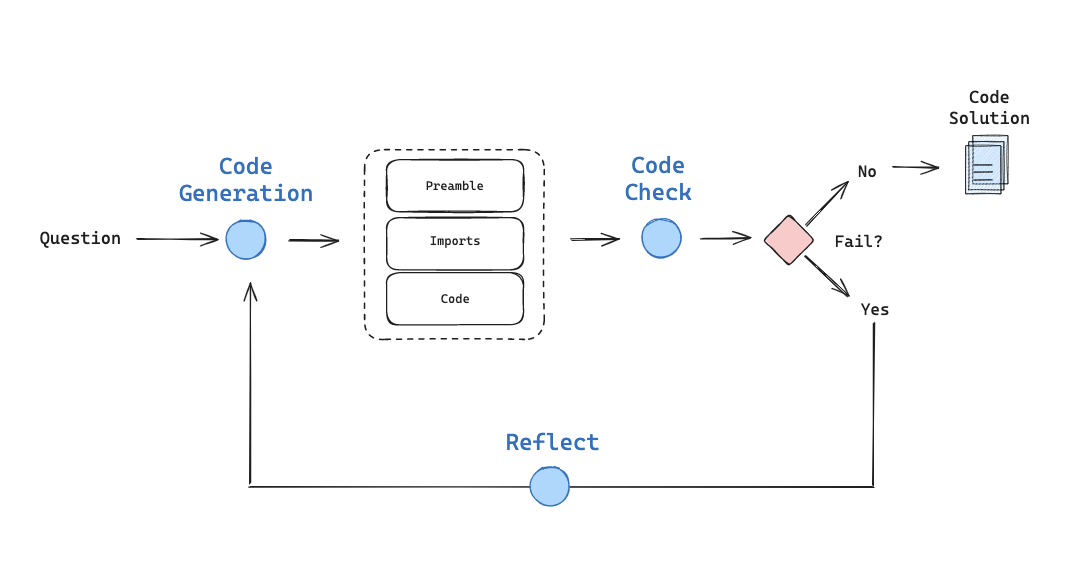


In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [3]:
print(concatenated_content)






Conceptual guide | ü¶úÔ∏èüîó LangChain







Skip to main contentLangChain 0.2 is out! Leave feedback on the v0.2 docs here. You can view the v0.1 docs here.IntegrationsAPI referenceLatestLegacyMorePeopleContributingCookbooks3rd party tutorialsYouTubearXivv0.2v0.2v0.1ü¶úÔ∏èüîóLangSmithLangSmith DocsLangChain HubJS/TS Docsüí¨SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a Simple LLM Application with LCELBuild a Query Analysis SystemBuild a ChatbotConversational RAGBuild an Extraction ChainBuild an AgentTaggingdata_generationBuild a Local RAG ApplicationBuild a PDF ingestion and Question/Answering systemBuild a Retrieval Augmented Generation (RAG) AppVector stores and retrieversBuild a Question/Answering system over SQL dataSummarize TextHow-to guidesHow-to guidesHow to use tools in a chainHow to use a vectorstore as a retrieverHow to add memory to chatbotsHow to use example selectorsHow to map values to a graph databaseH

# LLMs

## Lösung programmieren


In [4]:
from helpers import llm
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)


# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


llm = llm()
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"
# solution = code_gen_chain_oai.invoke({"context":concatenated_content,"messages":[("user",question)]})

In [5]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='Building a Retrieval-Augmented Generation (RAG) chain involves combining a retriever component that fetches relevant documents based on a query and a language model that generates responses using the retrieved documents as context. In LCEL, you can build a RAG chain using the following steps:', imports='from langchain_core.prompts import ChatPromptTemplate\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_community.retrievers import YourRetriever\n\n# Define your retriever\nretriever = YourRetriever()', code='# Define a chat model\nmodel = ChatOpenAI(model="gpt-4", temperature=0)\n\n# Create a prompt template for the model\nprompt_template = ChatPromptTemplate.from_template("{context}\\n\\nAnswer the question: {question}")\n\n# Combine components into a RAG chain\nrag_chain = prompt_template | retriever | model | StrOutputParser()', description='This code sets up a RAG chain in LCEL. It defines a retriever t

# State

Der Status ist ein Dict, das verschiedene Keys, die bei der Code-Erzeugung sind, enthält - also Fehler, Fragen, Codegeneration.


In [6]:
from typing import Dict, TypedDict, List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

# Graph

Der Graph geht nach dem oben beschriebenem Ablauf vor.


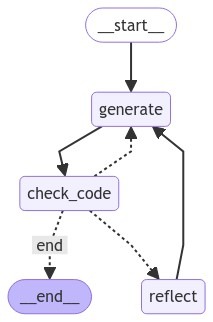

In [7]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", None)

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection
    reflection_message = [
        (
            "user",
            """You tried to solve this problem and failed a unit test. Reflect on this failure
                                    given the provided documentation. Write a few key suggestions based on the 
                                    documentation to avoid making this mistake again.""",
        )
    ]

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"


from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [11]:
question = "I've defined a LCEL runnable chain = prompt | model. How can I look at the input schema?"
# question = "How do i build a LCEL chain that can retrieve information from the internet?"
app.invoke({"messages": [("user", question)], "iterations": 3})


---GENERATING CODE SOLUTION---
---CHECKING CODE---
<class 'pydantic.v1.main.PromptInput'>
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   "I've defined a LCEL runnable chain = prompt | model. How can I look at the input schema?"),
  ('assistant',
   'To access the input schema of a LCEL runnable chain, you can use the `input_schema` attribute. This attribute provides the Pydantic model that describes the expected structure of inputs for the chain. \n Imports: from langchain_core.prompts import PromptTemplate\nfrom langchain_anthropic import ChatAnthropic \n Code: # Define a prompt template\nprompt = PromptTemplate.from_template("Tell me a joke about {topic}")\n\n# Define a model\nmodel = ChatAnthropic(model="claude-3-sonnet-20240229")\n\n# Create the LCEL chain\nchain = prompt | model\n\n# Access and print the input schema\ninput_schema = chain.input_schema\nprint(input_schema)')],
 'generation': code(prefix='To access the input schema of a LCEL runnable chain, you can use the `input_schema` attribute. This attribute provides the Pydantic model that describes the expected structu